 # Module

In [37]:
from dotenv import load_dotenv
import os
from pydantic import BaseModel
import functools
import operator
import json
from IPython.display import Image, display
from typing_extensions import TypedDict

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AIMessage, ToolMessage, HumanMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_experimental.tools import PythonREPLTool
from langgraph.prebuilt import create_react_agent
from langchain_experimental.utilities import PythonREPL

# .env 파일 로드
load_dotenv()
memory = MemorySaver()

# Create Agents
* 생성된 agent 들은 추후 graph상에서 node로 자리를 잡게 됨

In [6]:
def create_agent(llm, tools, system_message: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)
# MessagesPlaceholder는 프롬프트에서 동적인 "대화 기록"을 삽입하기 위한 자리표시자 역할

# Define Tools

In [10]:
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """
    Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Create Graph

* State

In [15]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

* Create Nodes

In [18]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

llm = ChatOpenAI(model="gpt-4o")

# Research Node
research_agent = create_agent(llm, 
                             [tavily_tool], 
                             system_message="You should provide accurate data for the chart_generator to use.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Coder Node
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Tool Node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

* Create Edge Logic

In [19]:
def router(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

* Define The Graph

In [38]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator",
     "call_tool": "call_tool",
     END:END}
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher",
     "call_tool": "call_tool",
     END:END}
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"], # state를 입력으로 받음
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator"
    },
)

workflow.add_edge(START, "Researcher")

graph = workflow.compile(
    checkpointer=MemorySaver()
)

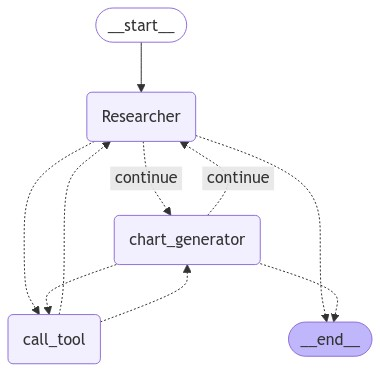

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Run

In [77]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 15 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    {"recursion_limit": 150,
     "configurable": {"thread_id": "1"}},
)
for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XoX0OapiLA1JzCHGINNr6dIl', 'function': {'arguments': '{"query":"UK GDP data past 15 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 17724, 'total_tokens': 17748, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 16896}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-98444d28-0ca6-4f4b-9ea8-b36d11780e4d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP data past 15 years'}, 'id': 'call_XoX0OapiLA1JzCHGINNr6dIl', 'type': 'tool_call'}], usage_metadata={'input_tokens': 17724, 'output_tokens': 24,

KeyboardInterrupt: 

# Check

In [42]:
state_values = graph.get_state({"configurable": {"thread_id": "1"}}).values["messages"]

In [49]:
for i in state_values:
    i

In [60]:
state_values

[HumanMessage(content="Fetch the UK's GDP over the past 15 years and 10, 5 years then draw these line graph of them independently. Once you code it up, finish.", additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oicofS4J6ef8lauvnFz3GsO8', 'function': {'arguments': '{"query": "UK GDP data past 15 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_7Mh5SrgpPsJ5Zmu2KHMqekrx', 'function': {'arguments': '{"query": "UK GDP data past 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_MgLifGbt25OfkfOONlaGcdC9', 'function': {'arguments': '{"query": "UK GDP data past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 224, 'total_tokens': 312, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejec

In [66]:
state_values[1].additional_kwargs["tool_calls"]

[{'id': 'call_oicofS4J6ef8lauvnFz3GsO8',
  'function': {'arguments': '{"query": "UK GDP data past 15 years"}',
   'name': 'tavily_search_results_json'},
  'type': 'function'},
 {'id': 'call_7Mh5SrgpPsJ5Zmu2KHMqekrx',
  'function': {'arguments': '{"query": "UK GDP data past 10 years"}',
   'name': 'tavily_search_results_json'},
  'type': 'function'},
 {'id': 'call_MgLifGbt25OfkfOONlaGcdC9',
  'function': {'arguments': '{"query": "UK GDP data past 5 years"}',
   'name': 'tavily_search_results_json'},
  'type': 'function'}]

In [71]:
a = state_values[4].content

In [72]:
a.count("url")

5

In [73]:
import ast
b = ast.literal_eval(a)

In [74]:
b

[{'url': 'https://www.statista.com/topics/3795/gdp-of-the-uk/',
  'content': 'Monthly growth of gross domestic product in the United Kingdom from January 2019 to November 2023\nContribution to GDP growth in the UK 2023, by sector\nContribution to gross domestic product growth in the United Kingdom in January 2023, by sector\nGDP growth rate in the UK 1999-2021, by country\nAnnual growth rates of gross domestic product in the United Kingdom from 1999 to 2021, by country\nGDP growth rate in the UK 2021, by region\nAnnual growth rates of gross domestic product in the United Kingdom in 2021, by region\nGDP growth of Scotland 2021, by local area\nAnnual growth rates of gross domestic product in Scotland in 2021, by local (ITL 3) area\nGDP growth of Wales 2021, by local area\nAnnual growth rates of gross domestic product in Wales in 2021, by local (ITL 3) area\nGDP growth of Northern Ireland 2021, by local area\nAnnual growth rates of gross domestic product in Northern Ireland in 2021, by lo